In [256]:
 
import urllib.request
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import re
import shifterator as sh
import matplotlib.pyplot as plt
labMTdata = pd.read_csv('labMT.csv')
filteredLabMTdata = labMTdata[ (labMTdata['Happiness Score'] <= 4) | (labMTdata['Happiness Score'] >= 6) ]


stories = {
    "pride_and_predjudice": {
        "url": "https://www.gutenberg.org/cache/epub/1342/pg1342.txt",
        },
    "frankenstein": {
        "url": "https://www.gutenberg.org/cache/epub/84/pg84.txt",
    },
    "moby_dick": {
        "url": "https://www.gutenberg.org/cache/epub/2701/pg2701.txt",
    },
    "le_miserables": {
        "url": "https://www.gutenberg.org/cache/epub/135/pg135.txt",
    }
}

def handleFrankenstein(text):
    ## specific fixes for Frankenstein text
    text = re.sub(r'D--n', 'Damn', text)
    return text

def handlePunctuation(text):
    ## separate out some basic punctuation
    text = re.sub(r'([!?,.])', r' \1 ', text)
    text = re.sub(r':', ' : ', text)
    text = re.sub(r';', r' ; ', text)
    ## remove underscores used for emphasis
    text = re.sub(r'_', '', text)
    ## isolate parentheses
    text = re.sub(r'\(', ' ( ', text)
    text = re.sub(r'\)', ' ) ', text)
    ## clean up white space duplication
    text = re.sub(r'\s+', ' ', text)
    ## remove leading whitespace only
    text = text.lstrip()

    return text

def handleDashMadness(text):
    ## dash madness
    text = re.sub(r'----', ' --- ', text)  ## long dash
    text = re.sub(r'--', ' --- ', text)  ## em dash
    text = re.sub(r';—', ' --- ', text)  ## em dash
    text = re.sub(r'—', ' --- ', text)  ## em dash
    # strip any single dashes that may remain
    text = re.sub(r' - ', ' ', text)
    ## clean up white space duplication
    text = re.sub(r'\s+', ' ', text)
    ## remove leading/trailing whitespace
    text = text.strip()
    return text

def handleSalutations(text):
    ## handle specific salutations
    text = re.sub(r'Mr \.', 'Mr.', text)
    text = re.sub(r'Mrs \.', 'Mrs.', text)
    text = re.sub(r'Dr \.', 'Dr.', text)
    return text


def preprocess_text(text):
    ## for Frankenstein
    text = handleFrankenstein(text)
    ## separate out some basic punctuation
    text = handlePunctuation(text)
    ## dash madness
    text = handleDashMadness(text)
    ## handle specific salutations
    text = handleSalutations(text)
    ## clean up white space duplication
    text = re.sub(r'\s+', ' ', text)
    ## separate quotes
    ## opening quotes should have a space before them (except for em dashes, treat
    text = re.sub(r'\s"', ' " ', text)
    ## closing quotes should be what's left:
    text = re.sub(r'"', ' " ', text)
    text = re.sub(r'"', ' " ', text)
    text = re.sub(r'"', ' " ', text)
    text = re.sub(r"'", " ' ", text)
    text = re.sub(r"'", "'", text)
    text = re.sub(r"(\s)'([a-zA-Z])", r"\1' \2", text)
    text = re.sub(r"([a-zA-Z])'(\s)", r"\1 '\2", text)
    text = re.sub(r"'s", " 's", text)
    ## add new line at the end
    text = text + "\n"
    # ## now create time series text by replacing spaces with returns
    timeseriestext = re.sub(r' ', '\n', text)
    # ## last: remove any white space redundancies
    timeseriestext = re.sub(r'\s+', '\n', timeseriestext, flags=re.MULTILINE | re.DOTALL)
    return timeseriestext

def extract_content_between(content, opening_string, closing_string):
    """
    Extracts content between opening_string and closing_string.
    
    Parameters:
    - content (str): The full text content
    - opening_string (str): The string marking the start
    - closing_string (str): The string marking the end
    
    Returns:
    - str: Content from opening_string to closing_string (inclusive), or None if not found
    """
    start_idx = content.find(opening_string)
    end_idx = content.find(closing_string)
    
    if start_idx == -1 or end_idx == -1:
        return None  # Strings not found
    
    return content[start_idx:end_idx + len(closing_string)]

def get_story(story_key):
    return stories[story_key]

def get_word_frequency(words):
    """
    Generates word counts.
    
    Parameters:
    - words (list): List of words to analyze for frequency.
    
    Returns:
    - DataFrame: DataFrame with word counts.
    """
    bow = pd.Series(words).value_counts().reset_index()
    bow.columns = ['word', 'counts']        
    bow = bow.sort_values(by='counts', ascending=False).reset_index(drop=True)
    return bow

def plot_zipf_distribution(words, story):
    """
    Plots the Zipf distribution for the given transcript.
    """        
    # Rank the words by frequency
    words['rank'] = words['counts'].rank(ascending=False, method='average').astype(int)
    
    # Log-transform rank and frequency
    log_rank = np.log10(words['rank'])
    log_freq = np.log10(words['counts'])
    
    # Perform linear regression to calculate the slope
    slope, intercept, r_value, p_value, std_err = linregress(log_rank, log_freq)
    
    # Plot the Zipf distribution (log-log scale)
    plt.figure(figsize=(5, 5))
    plt.loglog(words['rank'], words['counts'], marker=".", linestyle='none', color="grey")
    
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title(f'Zipf Law - {story}')
    plt.legend()
    plt.savefig(f"plots/{story}_zipf_log_space.png")
    plt.show()

def get_percentage_of_book(words, percentage):
    """
    Returns the first 'percentage' percent of the book as a list of words.

    Parameters:
    - words (list): List of words in the book.
    - percentage (float): Percentage of the book to return.
    """
    total_words = len(words)
    cutoff_index = int(total_words * (percentage / 100))
    return words[:cutoff_index]

def get_average_happiness(word_freq_df, labMTdata):
    total_weighted_score = 0
    total_count = 0
    
    # lowercase words for matching
    word_freq_df['word'] = word_freq_df['word'].str.lower()
    labMTdata['Word'] = labMTdata['Word'].str.lower()
    
    for idx, row in word_freq_df.iterrows():
        word = row['word']
        count = row['counts']
        
        if word in filteredLabMTdata['Word'].values:
            score = labMTdata.loc[labMTdata['Word'] == word, 'Happiness Score'].values[0]
            total_weighted_score += score * count  # Weight by frequency!
            total_count += count
    
    return total_weighted_score / total_count if total_count > 0 else 0

def get_word_shift_data(word_freq_df, labMTdata):
    """
    Returns a dataframe of words and their frequencies for words with happiness scores <=4 or >=6.
    """
    # create dataframe of words and their frequencies and happiness scores
    word_shift_data = {}
    for word in word_freq_df['word']:
        if word in filteredLabMTdata['Word'].values:
            if word not in word_shift_data:
                word_shift_data[word] = word_freq_df.loc[word_freq_df['word'] == word, 'counts'].values[0]
    return word_shift_data

['It', 'is', 'a', 'truth', 'universally', 'acknowledged', ',', 'that', 'a', 'single']
['Derbyshire', ',', 'had', 'been', 'the', 'means', 'of', 'uniting', 'them', '.']


/var/folders/02/c1hvrmj11kx0z457p84l6pbc0000gn/T/ipykernel_41608/603196770.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


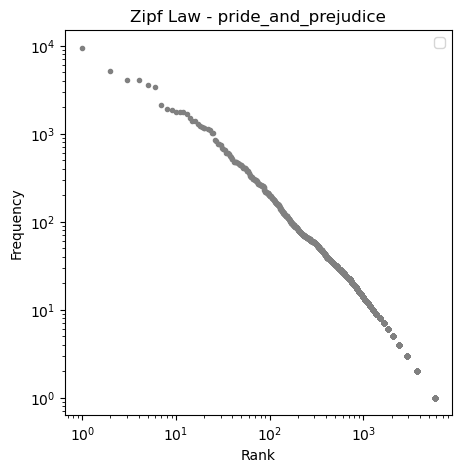

look at score
6.001938672922242
5.816509040333795


In [257]:
pride_and_prejudice = get_story("pride_and_predjudice")
url = pride_and_prejudice["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

# remove gutenberg header and footer
pride_and_prejudice_cleaned = extract_content_between(content, 'It is a truth universally acknowledged', 'had been the means of uniting them.')
processed_pride_and_prejudice = preprocess_text(pride_and_prejudice_cleaned)   
split_pride_and_prejudice = processed_pride_and_prejudice.splitlines()

print(split_pride_and_prejudice[:10])
print(split_pride_and_prejudice[-10:])
pride_word_freq_df = get_word_frequency(split_pride_and_prejudice)
pride_top_30_df = pride_word_freq_df.head(30)
pride_top_30_df.to_csv('pride_and_prejudice_top_30_n_grams.csv')

plot_zipf_distribution(pride_word_freq_df, "pride_and_prejudice")

# First 40% of the book
forty_percent_pride_and_prejudice = get_percentage_of_book(split_pride_and_prejudice, 40)

forty_percent_word_freq_df = get_word_frequency(forty_percent_pride_and_prejudice)

# Section from 70% to 75% of the book
start_70_percent = int(len(split_pride_and_prejudice) * 0.70)
end_75_percent = int(len(split_pride_and_prejudice) * 0.75)
seventy_to_seventy_five_percent = split_pride_and_prejudice[start_70_percent:end_75_percent]
seventy_to_seventy_five_percent_word_freq_df = get_word_frequency(seventy_to_seventy_five_percent)

# Now get word shift data
word_shift_data_ref = get_word_shift_data(get_word_frequency(forty_percent_pride_and_prejudice), labMTdata)
word_shift_data_comp = get_word_shift_data(get_word_frequency(seventy_to_seventy_five_percent), labMTdata)

print('look at score')
print(get_average_happiness(forty_percent_word_freq_df, labMTdata))
print(get_average_happiness(seventy_to_seventy_five_percent_word_freq_df, labMTdata))


In [258]:
# print first 20 tokens in pride and prejudice
print(split_pride_and_prejudice[:25])

['It', 'is', 'a', 'truth', 'universally', 'acknowledged', ',', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must', 'be', 'in', 'want', 'of', 'a', 'wife', '.']


In [259]:
pride_top_30_df.head(20)

,word,counts
0,",",9497
1,.,5126
2,to,4098
3,the,4076
4,of,3618
5,and,3404
6,her,2143
7,a,1905
8,was,1842
9,in,1780


In [260]:
# happiness for pride and prejudice
print(get_average_happiness(pride_word_freq_df, labMTdata))

5.972178626214415


In [261]:
# convert word shift data to dataframe and save as csv
word_shift_df_ref = pd.DataFrame(list(word_shift_data_ref.items()), columns=['word', 'frequency'])
word_shift_df_comp = pd.DataFrame(list(word_shift_data_comp.items()), columns=['word', 'frequency'])

# convert to csv
word_shift_df_ref.to_csv('ref.csv')
word_shift_df_comp.to_csv('comp.csv')

['To', 'Mrs.', 'Saville', ',', 'England', '.', 'St', '.', 'Petersburgh', ',']
['by', 'the', 'waves', 'and', 'lost', 'in', 'darkness', 'and', 'distance', '.']


/var/folders/02/c1hvrmj11kx0z457p84l6pbc0000gn/T/ipykernel_41608/603196770.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


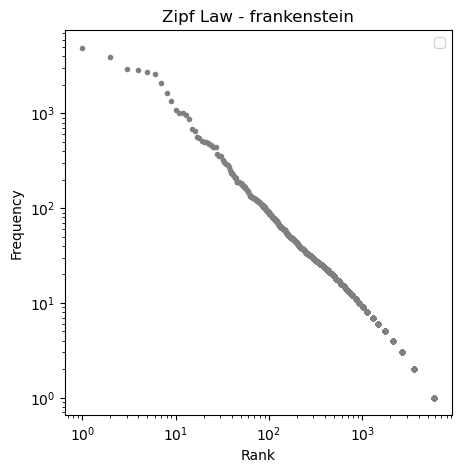

In [262]:
frankenstein = get_story("frankenstein")
url = frankenstein["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

# remove gutenberg header and footer
frankenstein_cleaned = extract_content_between(content, '_To Mrs. Saville, England._', 'lost in darkness and distance.')
processed_frankenstein = preprocess_text(frankenstein_cleaned)   
split_frankenstein = processed_frankenstein.splitlines()

print(split_frankenstein[:10])
print(split_frankenstein[-10:])
frankenstein_word_freq_df = get_word_frequency(split_frankenstein)
frankenstein_top_30_df = frankenstein_word_freq_df.head(30)
frankenstein_top_30_df.to_csv('frankenstein_top_30_n_grams.csv')
plot_zipf_distribution(frankenstein_word_freq_df, "frankenstein")


In [263]:
print(split_frankenstein[:69])

['To', 'Mrs.', 'Saville', ',', 'England', '.', 'St', '.', 'Petersburgh', ',', 'Dec', '.', '11th', ',', '17', '---', '.', 'You', 'will', 'rejoice', 'to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied', 'the', 'commencement', 'of', 'an', 'enterprise', 'which', 'you', 'have', 'regarded', 'with', 'such', 'evil', 'forebodings', '.', 'I', 'arrived', 'here', 'yesterday', ',', 'and', 'my', 'first', 'task', 'is', 'to', 'assure', 'my', 'dear', 'sister', 'of', 'my', 'welfare', 'and', 'increasing', 'confidence', 'in', 'the', 'success', 'of', 'my', 'undertaking', '.']


In [264]:
print(get_average_happiness(frankenstein_word_freq_df, labMTdata))

5.85711289294818


['Call', 'me', 'Ishmael', '.', 'Some', 'years', 'ago', '---', 'never', 'mind']
['after', 'her', 'missing', 'children', ',', 'only', 'found', 'another', 'orphan', '.']


/var/folders/02/c1hvrmj11kx0z457p84l6pbc0000gn/T/ipykernel_41608/603196770.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


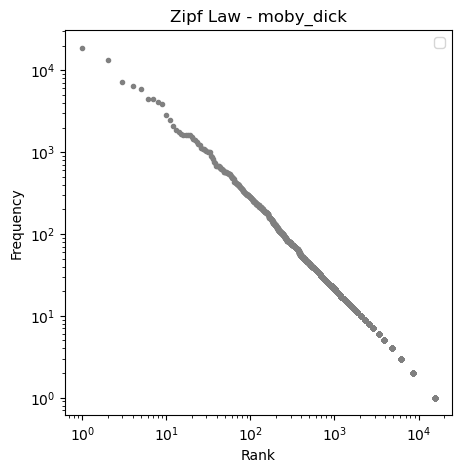

In [265]:
moby_dick = get_story("moby_dick")
url = moby_dick["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

# remove gutenberg header and footer
moby_dick_cleaned = extract_content_between(content, 'Call me Ishmael.', 'children, only found another orphan.')
processed_moby_dick = preprocess_text(moby_dick_cleaned)   
split_moby_dick = processed_moby_dick.splitlines()

print(split_moby_dick[:10])
print(split_moby_dick[-10:])
moby_dick_word_freq_df = get_word_frequency(split_moby_dick)
moby_dick_top_30_df = moby_dick_word_freq_df.head(30)
moby_dick_top_30_df.to_csv('moby_dick_top_30_n_grams.csv')
plot_zipf_distribution(moby_dick_word_freq_df, "moby_dick")



In [266]:
print(get_average_happiness(moby_dick_word_freq_df, labMTdata))

5.7976548444082185


In [267]:
print(split_moby_dick[:226])

['Call', 'me', 'Ishmael', '.', 'Some', 'years', 'ago', '---', 'never', 'mind', 'how', 'long', 'precisely', '---', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'I', 'thought', 'I', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.', 'It', 'is', 'a', 'way', 'I', 'have', 'of', 'driving', 'off', 'the', 'spleen', 'and', 'regulating', 'the', 'circulation', '.', 'Whenever', 'I', 'find', 'myself', 'growing', 'grim', 'about', 'the', 'mouth', ';', 'whenever', 'it', 'is', 'a', 'damp', ',', 'drizzly', 'November', 'in', 'my', 'soul', ';', 'whenever', 'I', 'find', 'myself', 'involuntarily', 'pausing', 'before', 'coffin', 'warehouses', ',', 'and', 'bringing', 'up', 'the', 'rear', 'of', 'every', 'funeral', 'I', 'meet', ';', 'and', 'especially', 'whenever', 'my', 'hypos', 'get', 'such', 'an', 'upper', 'hand', 'of', 'me', ',', 'that', 'it', 'requires', 

['In', '1815', ',', 'M', '.', 'Charles-François-Bienvenu', 'Myriel', 'was', 'Bishop', 'of']
['as', 'the', 'night', 'comes', 'when', 'day', 'is', 'gone', '.', ']']


/var/folders/02/c1hvrmj11kx0z457p84l6pbc0000gn/T/ipykernel_41608/603196770.py:164: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


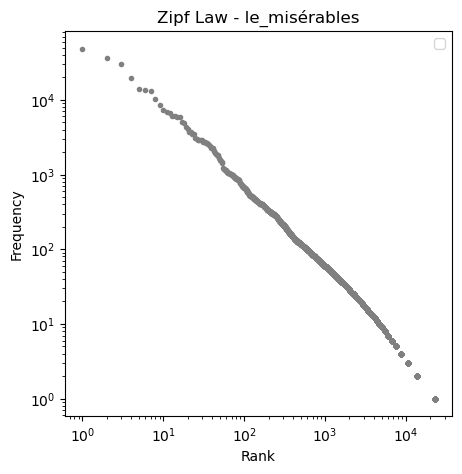

In [268]:
le_miserables = get_story("le_miserables")
url = le_miserables["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

# remove gutenberg header and footer
le_miserables_cleaned = extract_content_between(content, 'In 1815, M.', 'of itself, as the night comes when day is gone.]')
processed_le_miserables = preprocess_text(le_miserables_cleaned)   
split_le_miserables = processed_le_miserables.splitlines()

print(split_le_miserables[:10])
print(split_le_miserables[-10:])
le_miserables_word_freq_df = get_word_frequency(split_le_miserables)
le_miserables_top_30_df = le_miserables_word_freq_df.head(30)
le_miserables_top_30_df.to_csv('le_miserables_top_30_n_grams.csv')
plot_zipf_distribution(le_miserables_word_freq_df, "le_misérables")



In [269]:
print(get_average_happiness(le_miserables_word_freq_df, labMTdata))

5.733290147074651


In [270]:
print(split_le_miserables[:37])

['In', '1815', ',', 'M', '.', 'Charles-François-Bienvenu', 'Myriel', 'was', 'Bishop', 'of', 'D', '---', '---', 'He', 'was', 'an', 'old', 'man', 'of', 'about', 'seventy-five', 'years', 'of', 'age', ';', 'he', 'had', 'occupied', 'the', 'see', 'of', 'D', '---', '---', 'since', '1806', '.']
